In [1]:
import utils
import qiskit
import qiskit_aer
import numpy as np
from math import log
import qiskit.visualization
import matplotlib.pyplot as plt

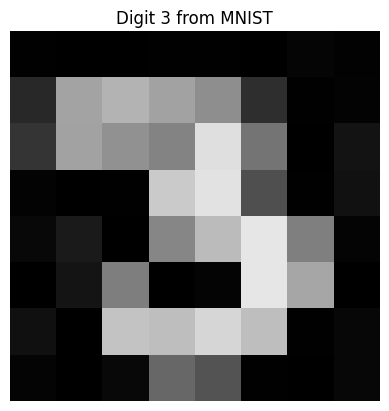

In [2]:
image = utils.plot_image('../images/three_8by8.jpg', 'Digit 3 from MNIST')

In [3]:
def equal_superposition(circ: qiskit.QuantumCircuit, start: int, end: int):
    circ.h([*range(start, end)])
        
def iterate_bitplane(circ: qiskit.QuantumCircuit, padding: int, current_state: str, next_state: str):
    n = len(current_state)
    
    # Indices we must apply an X gate to go from current_state to next_state 
    #   - Here we don't reverse the application! ->
    x_targets = np.array([idx + padding for idx in range(n) 
                          if current_state[idx] != next_state[idx]])

    if x_targets.size > 0:
        circ.x(x_targets)

def iterate_coordinate(circ: qiskit.QuantumCircuit, padding: int, current_state: str, next_state: str):
    n = len(current_state)
    
    # Indices we must apply an X gate to go from current_state to next_state 
    #   - We reverse the state strings because we set the coordinates qubits in the circuit
    #       in descending order.
    x_targets = np.array([idx + padding for idx in range(n) 
                          if current_state[::-1][idx] != next_state[::-1][idx]])
    if x_targets.size > 0:
        circ.x(x_targets)
        
def pixel_encoding(circ: qiskit.QuantumCircuit, control: list, intensity: str):
    for idx, val in enumerate(intensity[::-1]):
        if int(val):
            circ.mcx(control_qubits=control,
                     target_qubit=idx)

In [4]:
w_bits = int(np.ceil(log(image.shape[1], 2)))
h_bits = int(np.ceil(log(image.shape[0], 2)))

q = 8 # Length of binary string that represents intensity.

color_n_b = int(np.ceil(log(q, 2)))

color_reg = qiskit.QuantumRegister(1, 'Color')
ys_reg = qiskit.QuantumRegister(w_bits, 'Y axis')
xs_reg = qiskit.QuantumRegister(h_bits, 'X axis')
bitplane_reg = qiskit.QuantumRegister(color_n_b, 'Bitplanes')
creg = qiskit.ClassicalRegister(1+w_bits+h_bits+color_n_b, 'Bits')

brqi_circuit = qiskit.QuantumCircuit(color_reg, ys_reg, xs_reg, bitplane_reg, creg)

In [5]:
def construct_brqi(circ: qiskit.QuantumCircuit, image: np.array):
    num_qubits = circ.num_qubits
    
    equal_superposition(circ, 1, num_qubits)
    
    circ.barrier()
    
    for bitplane in range(q):
        bin_bitplane = '{0:0{1}b}'.format(bitplane-1, color_n_b)
        next_bitplane = '{0:0{1}b}'.format(bitplane, color_n_b)
        
        if bitplane > 0:
            iterate_bitplane(circ, color_reg.size + w_bits + h_bits, bin_bitplane, next_bitplane)
            
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                pixel_val = '{0:0{1}b}'.format(image[i, j], q)
                
                if int(pixel_val[bitplane]):
                    i_bit = '{0:0{1}b}'.format(i, h_bits)
                    #i_next_bit = '{0:0{1}b}'.format(i, h_bits)
                    
         
                    #iterate_coordinate(circ, color_reg.size + w_bits, i_bit, i_next_bit)
                        
                    for i_n, ibit in enumerate(i_bit):
                        if not int(ibit):
                            circ.x(xs_reg[i_n])
                        
                    j_bit = "{0:b}".format(j).zfill(w_bits)
                    
                    for j_n, jbit in enumerate(j_bit):
                        if jbit!='1':
                            circ.x(ys_reg[j_n])
                            
                    circ.barrier()
                    
                    controls = list(range(color_reg.size, num_qubits))
                    circ.mcx(controls, color_reg)

                    for j_n, jbit in enumerate(j_bit):
                        if jbit!='1':
                            circ.x(ys_reg[j_n] )

                    for i_n, ibit in enumerate(i_bit):
                        if ibit!='1':
                            circ.x(xs_reg[i_n])
                    circ.barrier()

    circ.barrier()
    
    to_measure = [*range(num_qubits)]
    
    circ.measure(list(reversed(range(num_qubits))), list(range(num_qubits)))

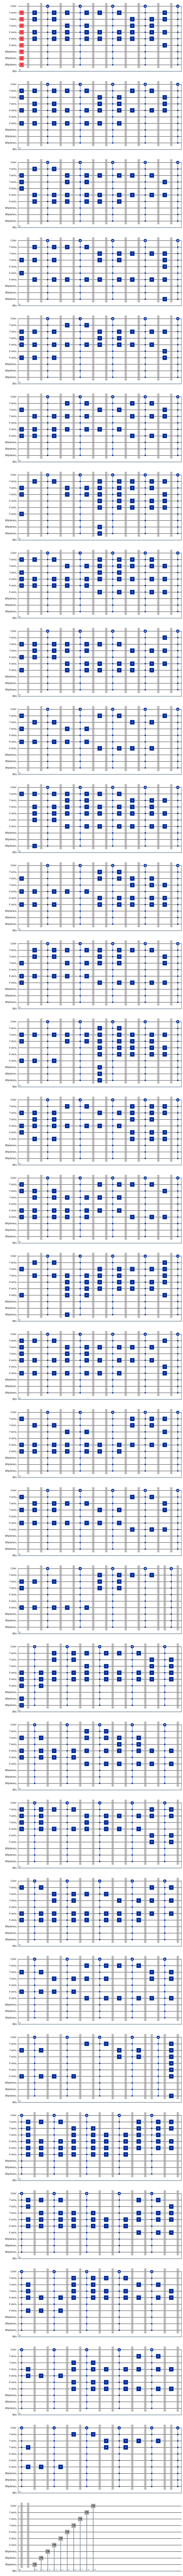

In [6]:
construct_brqi(brqi_circuit, image)
brqi_circuit.draw(output='mpl')

In [7]:
simulator = qiskit_aer.AerSimulator()
circuit = qiskit.transpile(brqi_circuit, simulator)
shots = 10000
result = simulator.run(circuit, shots=shots).result()

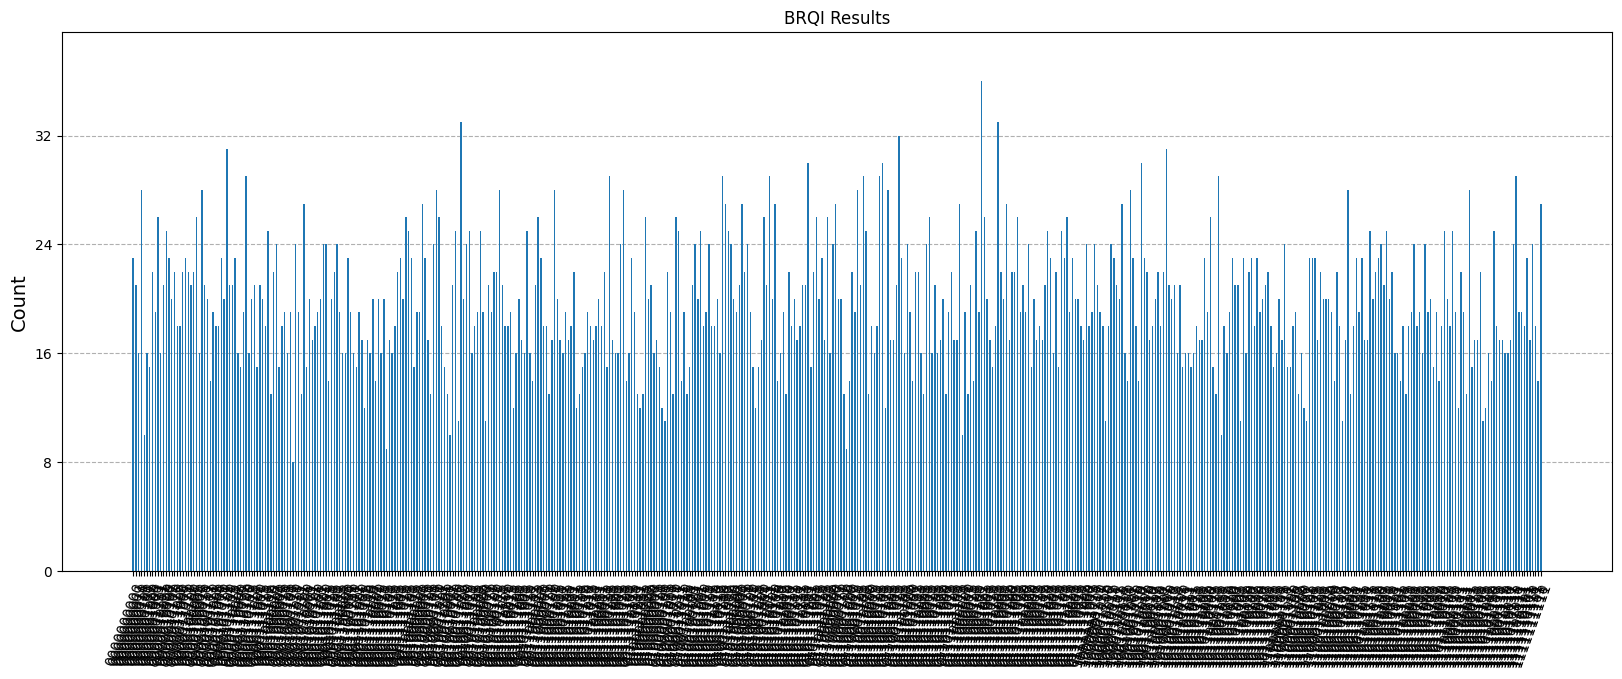

In [8]:
counts = result.get_counts(circuit)
qiskit.visualization.plot_histogram(counts, figsize=(20, 7), title="BRQI Results", bar_labels=False)

In [9]:
out_pixels = []
for item in counts:
    out_pixels.append((int(item[0:color_reg.size], 2),
                       int(item[color_reg.size:color_reg.size+xs_reg.size],2),
                       int(item[color_reg.size+xs_reg.size:color_reg.size+xs_reg.size+ys_reg.size],2),
                       int(item[color_reg.size+xs_reg.size+ys_reg.size:brqi_circuit.num_qubits],2)
                     ))
out_image = []
for k in range(image.shape[0]):
    for j in range(image.shape[1]):
        bits = [i for i in range(len(out_pixels)) if out_pixels[i][1] == k and out_pixels[i][2] == j]
        pixel = np.zeros((8,))
        for bit in bits:
            pixel[out_pixels[bit][3]] = int(out_pixels[bit][0])
        mystring = "".join([str(int(a)) for a in pixel])
        out_image.append(int(mystring, 2))
out_image = np.array(out_image).reshape(image.shape[1], image.shape[0]).T

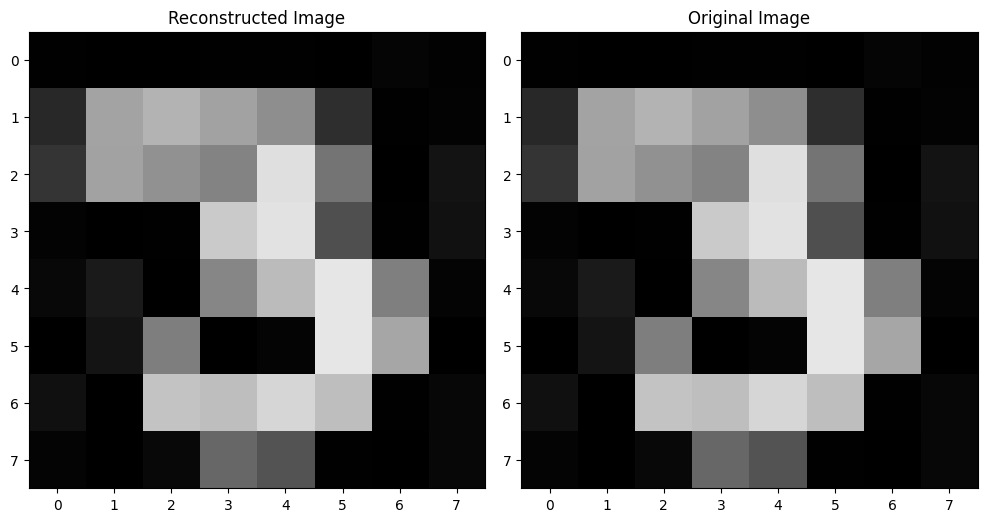

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(out_image, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Reconstructed Image')
axs[1].imshow(image, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Original Image')

plt.tight_layout()